In [105]:
import math
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

from src.data import *
from src.utils import *
from src.main import *
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [106]:
path = "./data/pp_gas_emission/"

data_2011 = pd.read_csv(path+"gt_2011.csv")
data_2012 = pd.read_csv(path+"gt_2012.csv")
data_2013 = pd.read_csv(path+"gt_2013.csv")
data_2014 = pd.read_csv(path+"gt_2014.csv")
data_2015 = pd.read_csv(path+"gt_2015.csv")

X_data_2011 = data_2011.drop(["CO", "NOX"], axis=1)
y_data_2011 = data_2011[["CO", "NOX"]]

X_data_2012 = data_2012.drop(["CO", "NOX"], axis=1)
y_data_2012 = data_2012[["CO", "NOX"]]

X_data_2013 = data_2013.drop(["CO", "NOX"], axis=1)
y_data_2013 = data_2013[["CO", "NOX"]]

X_data_2014 = data_2014.drop(["CO", "NOX"], axis=1)
y_data_2014 = data_2014[["CO", "NOX"]]

X_data_2015 = data_2015.drop(["CO", "NOX"], axis=1)
y_data_2015 = data_2015[["CO", "NOX"]]

X_data_train = np.concatenate([
    X_data_2011.to_numpy(),
    X_data_2012.to_numpy(),
    X_data_2013.to_numpy(),
    X_data_2014.to_numpy(),
], axis=0)

y_train = np.concatenate([
    y_data_2011.to_numpy(),
    y_data_2012.to_numpy(),
    y_data_2013.to_numpy(),
    y_data_2014.to_numpy(),
], axis=0)

X_data_weak = X_data_2015.to_numpy()
y_weak = y_data_2015.to_numpy()

X_all = np.concatenate([
            X_data_2011.to_numpy(),
            X_data_2012.to_numpy(),
            X_data_2013.to_numpy(),
            X_data_2014.to_numpy(),
            X_data_2015.to_numpy(),
        ], axis=0)

y_all = np.concatenate([
            y_data_2011.to_numpy(),
            y_data_2012.to_numpy(),
            y_data_2013.to_numpy(),
            y_data_2014.to_numpy(),
            y_data_2015.to_numpy(),
        ], axis=0)

cfg = {
    "beta":0.01,
    "gamma":0.01,
    "n_clusters":200,
    "n_models":10,
    "normalize_W":True,
    "verbose":True,
}

### Small

In [153]:
size = 1000
X_small_train = X_data_2011.to_numpy()
y_small_train = y_data_2011.to_numpy()

X_small_weak = X_data_2012.to_numpy()
y_small_weak = y_data_2012.to_numpy()

X_small_all = np.concatenate([
    X_small_train,
    X_small_weak
], axis=0)
y_small_all = np.concatenate([
    y_small_train,
    y_small_weak
], axis=0)

In [154]:
W_small_all = get_W_gaussian(X_small_all, normalize_W=cfg["normalize_W"])

In [155]:
neigh_50 = W_small_all.argsort()[:, -50:][:, ::-1]

In [156]:
L = []
for i in (pbar := tqdm(range(neigh_50.shape[0]))):
    neigh_20 = np.argpartition((y_all[neigh_50[i]]**2).sum(axis=1), 20)[:20]
    cov = np.cov(y_all[neigh_50[i]][neigh_20], rowvar=False)
    try:
        L_i = np.linalg.cholesky(cov)
        L_idx = np.tril_indices_from(L_i)
        L.append(L_i[L_idx])
    except LinAlgError:
        print("Cholesky Failed")
        break

100% 15039/15039 [00:01<00:00, 7864.49it/s]


In [157]:
L_small_all = np.stack(L)
A_small_all = y_small_all

In [162]:
L_small_train = L_small_all[:X_small_weak.shape[0]]
A_small_train = A_small_all[:X_small_weak.shape[0]]
L_small_weak = L_small_all[X_small_weak.shape[0]:]
A_small_weak = A_small_all[X_small_weak.shape[0]:]

In [163]:
X_small_full = np.concatenate([X_small_train, X_small_weak])
Y_small_full = np.concatenate([y_small_train, np.zeros_like(y_small_weak)])
L_small_full = np.concatenate([L_small_train, np.zeros_like(L_small_weak)])
B_small_full = np.diag(np.concatenate([np.ones(X_small_train.shape[0])*cfg["beta"] + 1, np.ones(X_small_weak.shape[0])*cfg["beta"]]))

In [ ]:
W_small = get_W_gaussian(X_small_full, normalize_W=cfg["normalize_W"])
print("")
print("1/2 Simmilarity constructed")
A_star, L_star = solve(W_small, B_small_full, Y_small_full, L_small_full, gamma=cfg["gamma"])
print("1/1 System Solved")
A_star_train, A_star_weak = A_star[:X_small_train.shape[0]], A_star[X_small_train.shape[0]:]
L_star_train, L_star_weak = L_star[:X_small_train.shape[0]], L_star[X_small_train.shape[0]:]


1/2 Simmilarity constructed


In [ ]:
get_Wasserstain(A_small_weak, L_small_weak, A_star_weak, L_star_weak), get_Wasserstain(A_small_train, L_small_train, A_star_train, L_star_train)

#### Estimating Noise

In [4]:
scaleX_all = StandardScaler()
X_all = scaleX_all.fit_transform(X_all)

#scaleY_all = StandardScaler()
#y_all = scaleY_all.fit_transform(y_all)

W_all = get_W_k_means(X_all, n_clusters=cfg["n_clusters"], n_models = cfg["n_models"], normalize_W=cfg["normalize_W"], verbose=cfg["verbose"])
neigh_50 = W_all.argsort()[:, :50]

L = []
for i in (pbar := tqdm(range(neigh_50.shape[0]))):
    neigh_20 = np.argpartition((y_all[neigh_50[i]]**2).sum(axis=1), 20)[:20]
    cov = np.cov(y_all[neigh_50[i]][neigh_20], rowvar=False)
    try:
        L_i = np.linalg.cholesky(cov)
        L_idx = np.tril_indices_from(L_i)
        L.append(L_i[L_idx])
    except LinAlgError:
        print("Cholesky Failed")
        break
        
L_all = np.stack(L)
A_all = y_all

L_train = L_all[:X_data_train.shape[0]]
A_train = A_all[:X_data_train.shape[0]]
L_weak = L_all[X_data_train.shape[0]:]
A_weak = A_all[X_data_train.shape[0]:]

Fitting 10 KMeans models: 1 2 3 4 5 6 7 8 9 10 

100% 36733/36733 [00:04<00:00, 8248.81it/s]


#### Model

In [5]:
scaleX = StandardScaler()
scaleY = StandardScaler()

X_train = scaleX.fit_transform(X_data_train)
X_weak = scaleX.transform(X_data_weak)

y_train = scaleY.fit_transform(y_train)
y_weak = scaleY.transform(y_weak)

In [6]:
X_full = np.concatenate([X_train, X_weak])
Y_full = np.concatenate([y_train, np.zeros_like(y_weak)])
L_full = np.concatenate([L_train, np.zeros_like(L_weak)])
B_full = np.diag(np.concatenate([np.ones(X_train.shape[0])*cfg["beta"] + 1, np.ones(X_weak.shape[0])*cfg["beta"]]))

In [7]:
W = get_W_k_means(X_full, n_clusters=cfg["n_clusters"], n_models = cfg["n_models"], normalize_W=cfg["normalize_W"], verbose=cfg["verbose"])
print("")
print("1/2 Simmilarity constructed")
A_star, L_star = solve(W, B_full, Y_full, L_full, gamma=cfg["gamma"])
print("1/1 System Solved")
A_star_train, A_star_weak = A_star[:X_train.shape[0]], A_star[X_train.shape[0]:]
L_star_train, L_star_weak = L_star[:X_train.shape[0]], L_star[X_train.shape[0]:]

Fitting 10 KMeans models: 1 2 3 4 5 6 7 8 9 10 
1/2 Simmilarity constructed
1/1 System Solved


In [8]:
print('KMeans similarity Weak: {}, Train: {}'.format(get_Wasserstain(A_weak, L_weak, A_star_weak, L_star_weak), get_Wasserstain(A_train, L_train, A_star_train, L_star_train)))

KMeans Simelarity Weak: 1.4236289916819733, Train: 0.020870123143848705


In [9]:
W = get_W_gaussian(X_full, normalize_W=cfg["normalize_W"])
print("")
print("1/2 Simmilarity constructed")
A_star, L_star = solve(W, B_full, Y_full, L_full, gamma=cfg["gamma"])
print("1/1 System Solved")
A_star_train, A_star_weak = A_star[:X_train.shape[0]], A_star[X_train.shape[0]:]
L_star_train, L_star_weak = L_star[:X_train.shape[0]], L_star[X_train.shape[0]:]


1/2 Simmilarity constructed
1/1 System Solved


In [10]:
print('Gaussian similarity Weak: {}, Train: {}'.format(get_Wasserstain(A_weak, L_weak, A_star_weak, L_star_weak), get_Wasserstain(A_train, L_train, A_star_train, L_star_train)))

Gaussian similarity Weak: 1.4727027075913477, Train: 0.02095116656050557


In [12]:
idxes_L_diag = []
k = 0
for i in range(2, 4):
    idxes_L_diag.append(k)
    k+=i

W = get_W_gaussian(X_full, normalize_W=cfg["normalize_W"])
print("")
print("1/2 Simmilarity constructed")

L_full_diag = L_full[:, idxes_L_diag]
A_star, L_star = solve(W, B_full, Y_full, L_full_diag, gamma=cfg["gamma"])
print("1/1 System Solved")
A_star_train, A_star_weak = A_star[:X_train.shape[0]], A_star[X_train.shape[0]:]
L_star_train, L_star_weak = L_star[:X_train.shape[0]], L_star[X_train.shape[0]:]

L_star_single_weak = np.zeros_like(L_weak)
L_star_single_weak[:, idxes_L_diag] = L_star_weak
L_star_single_train = np.zeros_like(L_train)
L_star_single_train[:, idxes_L_diag] = L_star_train


1/2 Simmilarity constructed
1/1 System Solved


In [13]:
print('Gaussian similarity single output Weak: {}, Train: {}'.format(
    get_Wasserstain(A_weak, L_weak, A_star_weak, L_star_single_weak),
    get_Wasserstain(A_train, L_train, A_star_train, L_star_single_train)
))

Gaussian similarity single output Weak: 1.4729638686981654, Train: 0.022668544542659912


In [16]:
idxes_L_diag = []
k = 0
for i in range(2, 4):
    idxes_L_diag.append(k)
    k+=i

W = get_W_k_means(X_full, n_clusters=cfg["n_clusters"], n_models = cfg["n_models"], normalize_W=cfg["normalize_W"], verbose=cfg["verbose"])
print("")
print("1/2 Simmilarity constructed")

L_full_diag = L_full[:, idxes_L_diag]
A_star, L_star = solve(W, B_full, Y_full, L_full_diag, gamma=cfg["gamma"])
print("1/1 System Solved")
A_star_train, A_star_weak = A_star[:X_train.shape[0]], A_star[X_train.shape[0]:]
L_star_train, L_star_weak = L_star[:X_train.shape[0]], L_star[X_train.shape[0]:]

L_star_single_weak = np.zeros_like(L_weak)
L_star_single_weak[:, idxes_L_diag] = L_star_weak
L_star_single_train = np.zeros_like(L_train)
L_star_single_train[:, idxes_L_diag] = L_star_train

Fitting 10 KMeans models: 1 2 3 4 5 6 7 8 9 10 
1/2 Simmilarity constructed
1/1 System Solved


In [17]:
print('KMeans similarity single output Weak: {}, Train: {}'.format(
    get_Wasserstain(A_weak, L_weak, A_star_weak, L_star_single_weak),
    get_Wasserstain(A_train, L_train, A_star_train, L_star_single_train)
))

KMeans similarity single output Weak: 1.395397555178696, Train: 0.02258449689190106


### No normalization

In [86]:
results_no_scale = {
    "MultiKMeans":[],
    "MultiGauss":[],
    "SingleKMeans":[],
    "SingleGauss":[],
}

In [87]:
path = "./data/pp_gas_emission/"

data_2011 = pd.read_csv(path+"gt_2011.csv")
data_2012 = pd.read_csv(path+"gt_2012.csv")
data_2013 = pd.read_csv(path+"gt_2013.csv")
data_2014 = pd.read_csv(path+"gt_2014.csv")
data_2015 = pd.read_csv(path+"gt_2015.csv")

X_data_2011 = data_2011.drop(["CO", "NOX"], axis=1)
y_data_2011 = data_2011[["CO", "NOX"]]

X_data_2012 = data_2012.drop(["CO", "NOX"], axis=1)
y_data_2012 = data_2012[["CO", "NOX"]]

X_data_2013 = data_2013.drop(["CO", "NOX"], axis=1)
y_data_2013 = data_2013[["CO", "NOX"]]

X_data_2014 = data_2014.drop(["CO", "NOX"], axis=1)
y_data_2014 = data_2014[["CO", "NOX"]]

X_data_2015 = data_2015.drop(["CO", "NOX"], axis=1)
y_data_2015 = data_2015[["CO", "NOX"]]

X_data_train = np.concatenate([
    X_data_2011.to_numpy(),
    X_data_2012.to_numpy(),
    X_data_2013.to_numpy(),
    X_data_2014.to_numpy(),
], axis=0)

y_train = np.concatenate([
    y_data_2011.to_numpy(),
    y_data_2012.to_numpy(),
    y_data_2013.to_numpy(),
    y_data_2014.to_numpy(),
], axis=0)

X_data_weak = X_data_2015.to_numpy()
y_weak = y_data_2015.to_numpy()

X_all = np.concatenate([
            X_data_2011.to_numpy(),
            X_data_2012.to_numpy(),
            X_data_2013.to_numpy(),
            X_data_2014.to_numpy(),
            X_data_2015.to_numpy(),
        ], axis=0)

y_all = np.concatenate([
            y_data_2011.to_numpy(),
            y_data_2012.to_numpy(),
            y_data_2013.to_numpy(),
            y_data_2014.to_numpy(),
            y_data_2015.to_numpy(),
        ], axis=0)

#scaleX_all = StandardScaler()
#X_all = scaleX_all.fit_transform(X_all)

W_all = get_W_k_means(X_all, n_clusters=cfg["n_clusters"], n_models = cfg["n_models"], normalize_W=cfg["normalize_W"], verbose=cfg["verbose"])
neigh_50 = W_all.argsort()[:, :50]

L = []
for i in (pbar := tqdm(range(neigh_50.shape[0]))):
    neigh_20 = np.argpartition((y_all[neigh_50[i]]**2).sum(axis=1), 20)[:20]
    cov = np.cov(y_all[neigh_50[i]][neigh_20], rowvar=False)
    try:
        L_i = np.linalg.cholesky(cov)
        L_idx = np.tril_indices_from(L_i)
        L.append(L_i[L_idx])
    except LinAlgError:
        print("Cholesky Failed")
        break
        
L_all = np.stack(L)
A_all = y_all

L_train = L_all[:X_data_train.shape[0]]
A_train = A_all[:X_data_train.shape[0]]
L_weak = L_all[X_data_train.shape[0]:]
A_weak = A_all[X_data_train.shape[0]:]

#scaleX = StandardScaler()

#X_train = scaleX.fit_transform(X_data_train)
#X_weak = scaleX.transform(X_data_weak)

X_train = X_data_train
X_weak = X_data_weak

Fitting 10 KMeans models: 1 2 3 4 5 6 7 8 9 10 

100% 36733/36733 [00:04<00:00, 8388.23it/s]


In [104]:
W.min(1)

array([0., 0., 0., ..., 0., 0., 0.])

In [88]:
X_full = np.concatenate([X_train, X_weak])
Y_full = np.concatenate([y_train, np.zeros_like(y_weak)])
L_full = np.concatenate([L_train, np.zeros_like(L_weak)])
B_full = np.diag(np.concatenate([np.ones(X_train.shape[0])*cfg["beta"] + 1, np.ones(X_weak.shape[0])*cfg["beta"]]))

In [89]:
cfg["normalize_W"] = False

In [90]:
W_kmeans = get_W_k_means(X_full, n_clusters=cfg["n_clusters"], n_models = cfg["n_models"], normalize_W=cfg["normalize_W"], verbose=cfg["verbose"])
W_gauss = get_W_gaussian(X_full, normalize_W=cfg["normalize_W"])

Fitting 10 KMeans models: 1 2 3 4 5 6 7 8 9 10 

In [96]:
A_star, L_star = solve(W_kmeans, B_full, Y_full, L_full, gamma=cfg["gamma"])
A_star_train, A_star_weak = A_star[:X_train.shape[0]], A_star[X_train.shape[0]:]
L_star_train, L_star_weak = L_star[:X_train.shape[0]], L_star[X_train.shape[0]:]
results_no_scale["MultiKMeans"] = [get_Wasserstain(A_weak, L_weak, A_star_weak, L_star_weak), get_Wasserstain(A_train, L_train, A_star_train, L_star_train)]

In [97]:
A_star, L_star = solve(W_gauss, B_full, Y_full, L_full, gamma=cfg["gamma"])
A_star_train, A_star_weak = A_star[:X_train.shape[0]], A_star[X_train.shape[0]:]
L_star_train, L_star_weak = L_star[:X_train.shape[0]], L_star[X_train.shape[0]:]
results_no_scale["MultiGauss"] = [get_Wasserstain(A_weak, L_weak, A_star_weak, L_star_weak), get_Wasserstain(A_train, L_train, A_star_train, L_star_train)]

In [98]:
idxes_L_diag = []
k = 0
for i in range(2, 4):
    idxes_L_diag.append(k)
    k+=i
    
L_full_diag = L_full[:, idxes_L_diag]

In [ ]:
A_star, L_star = solve(W_kmeans, B_full, Y_full, L_full_diag, gamma=cfg["gamma"])
A_star_train, A_star_weak = A_star[:X_train.shape[0]], A_star[X_train.shape[0]:]
L_star_train, L_star_weak = L_star[:X_train.shape[0]], L_star[X_train.shape[0]:]

L_star_single_weak = np.zeros_like(L_weak)
L_star_single_weak[:, idxes_L_diag] = L_star_weak
L_star_single_train = np.zeros_like(L_train)
L_star_single_train[:, idxes_L_diag] = L_star_train

results_no_scale["SingleKMeans"] = [get_Wasserstain(A_weak, L_weak, A_star_weak, L_star_single_weak), get_Wasserstain(A_train, L_train, A_star_train, L_star_single_train)]

In [ ]:
A_star, L_star = solve(W_gauss, B_full, Y_full, L_full_diag, gamma=cfg["gamma"])
A_star_train, A_star_weak = A_star[:X_train.shape[0]], A_star[X_train.shape[0]:]
L_star_train, L_star_weak = L_star[:X_train.shape[0]], L_star[X_train.shape[0]:]

L_star_single_weak = np.zeros_like(L_weak)
L_star_single_weak[:, idxes_L_diag] = L_star_weak
L_star_single_train = np.zeros_like(L_train)
L_star_single_train[:, idxes_L_diag] = L_star_train

results_no_scale["SingleGauss"] = [get_Wasserstain(A_weak, L_weak, A_star_weak, L_star_single_weak), get_Wasserstain(A_train, L_train, A_star_train, L_star_single_train)]

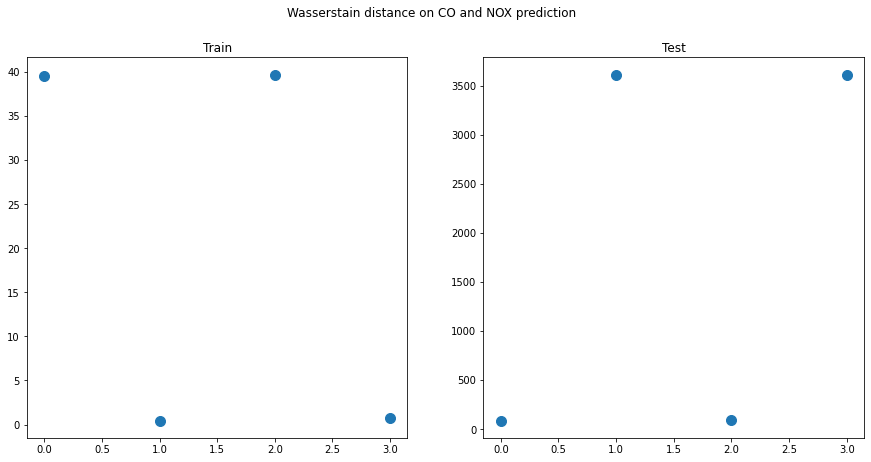

In [102]:
plt.figure(figsize=(15, 7))
plt.suptitle('Wasserstain distance on CO and NOX prediction')
ax1 = plt.subplot(121)
ax1.set_title("Train")
ax1.scatter(np.arange(len(results_no_scale.items())), [x[1] for _, x in results_no_scale.items()], s=100)

ax2 = plt.subplot(122)
ax2.set_title("Test")
ax2.scatter(np.arange(len(results_no_scale.items())), [[x[0] for _, x in results_no_scale.items()]], s=100)

plt.show()